In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

from causal_ccm.causal_ccm import ccm
from pyEDM import *

from time import process_time

from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

---

In [2]:
time_slice = slice('1963-10-01','2018-09-01')

## ENSO

In [3]:
# ENSO nino34
# This just reads the data from an url
# Sea Surface Temperature (SST) data from http://www.cpc.ncep.noaa.gov/data/indices/
url = 'http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True)

# Parse the time and convert to xarray
time = pd.to_datetime(df.YR.astype(str) + '-' + df.MON.astype(str))
nino34 = xr.DataArray(df.ANOM, dims='time', coords={'time':time})
# Apply a 3-month smoothing window
nino34 = nino34.rolling(time=5, min_periods=3, center=True).mean()
# Select the ERA5 period
nino34 = nino34.sel(time=time_slice)

# # find periods of El Ninos and La Ninas
# ElNinos = nino34.where(nino34 >= 0.5, drop=True)
# LaNinas = nino34.where(nino34 <= -0.5, drop=True)

In [4]:
# # backup in case cell above doesn't work
# df = pd.read_fwf('./data/ENSO/nino34_psl.txt', skiprows=1, na_values = 99.99,
#                  names=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# df = df.iloc[0:155]

# df_ts = df.stack().reset_index()
# df_ts['time'] = df_ts['level_0']+'-'+df_ts['level_1']
# df_ts['time'] = pd.to_datetime(df_ts['time'], format='%Y-%b')

# df_ts = df_ts.drop(['level_0', 'level_1'], axis=1)
# df_ts.set_index('time', inplace=True)
# df_ts.columns = ['ANOM']

# nino34 = df_ts.to_xarray()
# nino34['ANOM'] = nino34['ANOM'].astype('float32')
# nino34.ANOM.sel(time=slice('1949-10-01', '2018-09-30')).plot()
# nino34 = nino34.rolling(time=5, min_periods=3, center=True).mean()


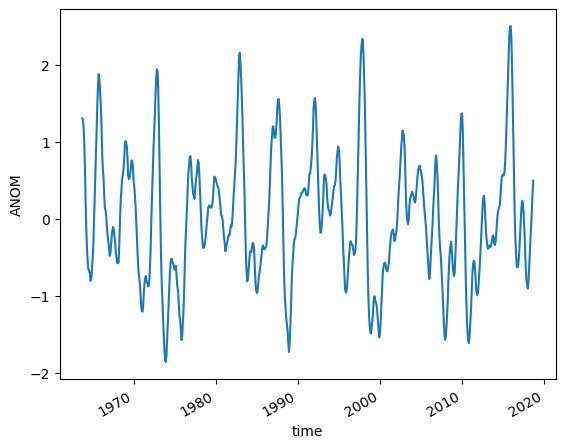

In [5]:
nino34.plot()

## PDO

In [6]:
pdo = xr.open_dataset('./data/PDO/pdo.timeseries.ersstv5.nc')
pdo = pdo.sel(time=time_slice)
# pdo_season = pdo.resample(time='QS-DEC').mean(dim='time')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/hkim139/Documents/research/snow_causal/causal_snow_proj/data/PDO/pdo.timeseries.ersstv5.nc'

# SST

In [7]:
f = xr.open_dataset('./data/ERSST/sst.mnmean.nc')
ssts = f.sel(time=time_slice)

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/hkim139/Documents/research/snow_causal/causal_snow_proj/data/ERSST/sst.mnmean.nc'

In [13]:
ssts.sel(lat=slice(60,-20))

<xarray.Dataset>
Dimensions:    (lat: 41, lon: 180, time: 660, nbnds: 2)
Coordinates:
  * lat        (lat) float32 60.0 58.0 56.0 54.0 ... -14.0 -16.0 -18.0 -20.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2018-09-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-04-04

In [14]:
# For North Pacific Ocean
ssts_np = ssts.sel(lon=slice(180,280), lat = slice(60,-20))

# gb = ssts_np.sst.groupby('time.month')
# clim_sst = gb.mean(dim='time')

# anom = gb - clim_sst

# remove monthly means from North Pacific SSTs
ssta_np = xr.apply_ufunc(
    lambda x, mean: x - mean, 
    ssts_np.sst.groupby('time.month'),
    ssts_np.sst.groupby('time.month').mean(dim='time')
).drop('month')

In [1]:
ssts_np

NameError: name 'ssts_np' is not defined

In [122]:
# ssta_np.to_netcdf('./data/processed/SWE_anoms.nc')

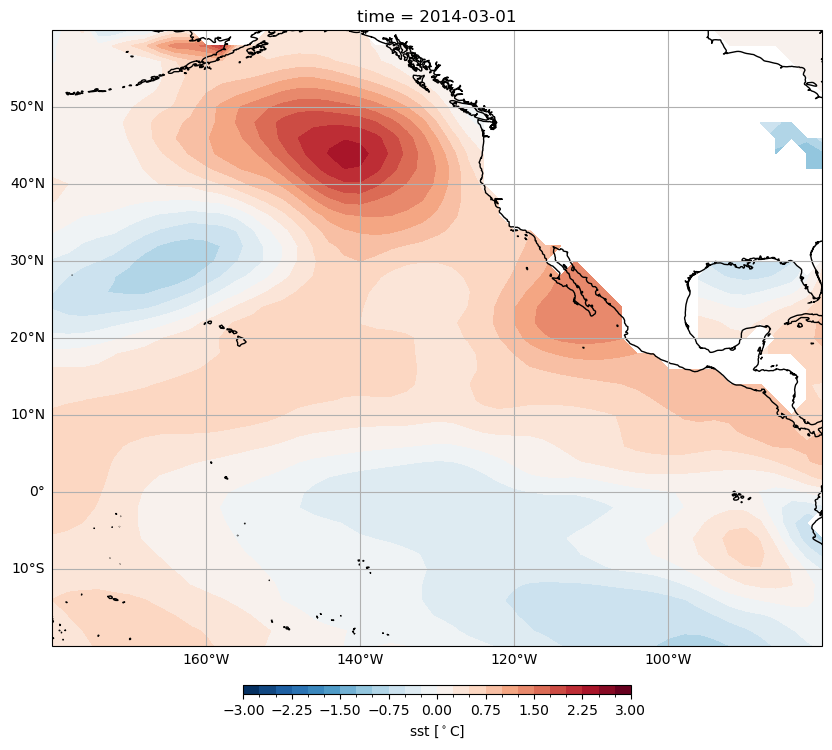

In [17]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.5, 'aspect':40,
               'label':r'sst [$^\circ$C]',
               'orientation':'horizontal', 
               'pad':0.05}

gl = ax.gridlines(draw_labels=True)
# gl.xlocator = mticker.FixedLocator(np.arange())
# gl.ylocator = mticker.FixedLocator(np.arange())
gl.right_labels = False
gl.top_labels = False

sst_levels = np.arange(-3,3.1,0.25)

ssta_np.sel(time='2014-03-01').plot.contourf(ax=ax,
                                 levels = sst_levels,
                                 transform=ccrs.PlateCarree(),
                                 cbar_kwargs=cbar_kwargs)

# ssta_eq.sel(time='2014-03-01').plot.contourf(ax=ax,
#                                  levels = sst_levels,
#                                  transform=ccrs.PlateCarree(),add_colorbar=False,)
#                                  #cbar_kwargs=cbar_kwargs)
plt.show()

## SLP

In [1]:
# f = xr.open_dataset('./data/NCEP-NCAR/reanalysis2/mslp.mon.mean.nc')
# slps = f.sel(time=time_slice)
# slps = slps.sel(lon=slice(180,280), lat = slice(60,-20))

# slps['mslp']= slps['mslp']/100

In [2]:
# # https://stackoverflow.com/a/74489930
# slp_anomalies = xr.apply_ufunc(
#     lambda x, mean: x - mean, 
#     slps.mslp.groupby('time.month'),
#     slps.mslp.groupby('time.month').mean()
# ).drop('month')

In [3]:
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# ax.coastlines(resolution='50m', color='black', linewidth=1)

# ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels=True)
# # gl.xlocator = mticker.FixedLocator(np.arange(-180,-115,10))
# # gl.ylocator = mticker.FixedLocator(np.arange(-30,80.1,10))
# gl.ylocator = LatitudeLocator()

# gl.right_labels = False
# gl.top_labels = False
# # gl.xlines=False
# # gl.ylines=False
# # ax.add_feature(cfeature.STATES, alpha=0.3)
# #     ax.add_feature(cfeature.LAKES, alpha=0.5)
# #     ax.add_feature(cfeature.RIVERS)
# # ax.add_feature(cfeature.OCEAN)
# #     ax.add_feature(cfeature.LAND)

# cbar_kwargs = {'shrink':0.6, 'aspect':40,
#                'label':r'SLP [mb]',
#                'orientation':'horizontal', 
#                'pad':0.05}
# slp_levels = np.arange(-10,10.1,1)
# slp_anomalies.sel(time='2014-03-01').plot.contourf(ax=ax,
#                                                    levels = slp_levels,
#                                           transform=ccrs.PlateCarree(),
#                                           cbar_kwargs=cbar_kwargs)

# plt.show()

In [21]:
f = xr.open_dataset('./data/NCEP-NCAR/reanalysis1/slp.mon.mean.nc')
slps = f.sel(time=time_slice)
slps = slps.sel(lon=slice(180,280), lat = slice(60,-20))

In [22]:
# https://stackoverflow.com/a/74489930
slp_anomalies = xr.apply_ufunc(
    lambda x, mean: x - mean, 
    slps.slp.groupby('time.month'),
    slps.slp.groupby('time.month').mean()
).drop('month')

In [121]:
slp_anomalies.to_netcdf('./data/processed/SLP_anoms.nc')

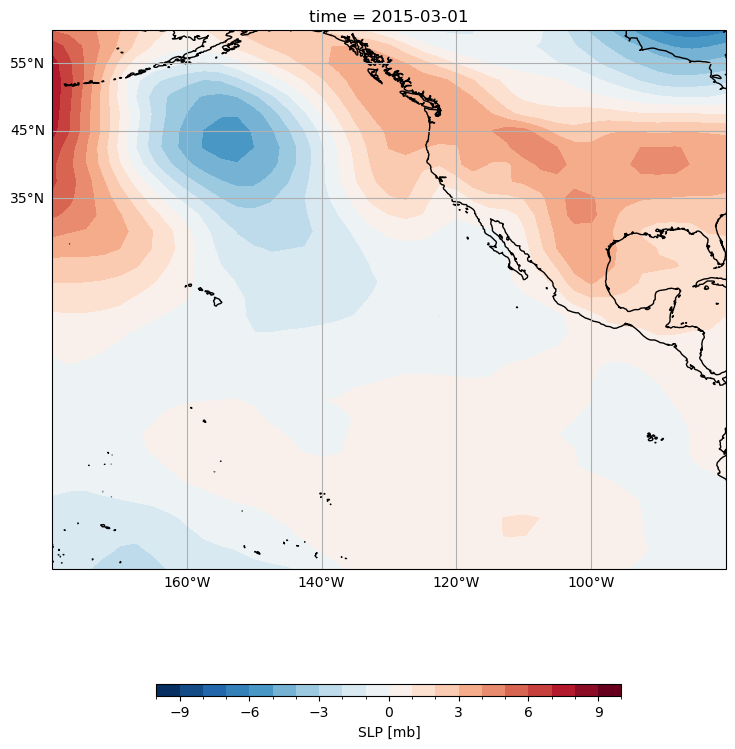

In [25]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
# gl.xlocator = mticker.FixedLocator(np.arange(-180,-115,10))
gl.ylocator = mticker.FixedLocator(np.arange(35,75.1,10))
gl.right_labels = False
gl.top_labels = False
# gl.xlines=False
# gl.ylines=False
# ax.add_feature(cfeature.STATES, alpha=0.3)
#     ax.add_feature(cfeature.LAKES, alpha=0.5)
#     ax.add_feature(cfeature.RIVERS)
# ax.add_feature(cfeature.OCEAN)
#     ax.add_feature(cfeature.LAND)

cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'SLP [mb]',
               'orientation':'horizontal'}
slp_levels = np.arange(-10,10.1,1)
slp_anomalies.sel(time='2015-03-01').plot.contourf(ax=ax,
                                                   levels = slp_levels,
                                                   transform=ccrs.PlateCarree(),
                                                   cbar_kwargs=cbar_kwargs)

plt.show()

## Omega

In [26]:
# f = xr.open_dataset('./data/NCEP-NCAR/reanalysis2/omega.mon.mean.nc')
f = xr.open_dataset('./data/NCEP-NCAR/reanalysis1/omega.mon.mean.nc')

omega = f.sel(time=slice('1983-01-01', '2023-03-01'))
omega = omega.sel(lon=slice(180,280), lat = slice(60,-20))

In [27]:
omega_surf = omega.isel(level=0)

In [28]:
omega_surf

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 41, time: 483)
Coordinates:
    level    float32 1e+03
  * lat      (lat) float32 60.0 57.5 55.0 52.5 50.0 ... -12.5 -15.0 -17.5 -20.0
  * lon      (lon) float32 180.0 182.5 185.0 187.5 ... 272.5 275.0 277.5 280.0
  * time     (time) datetime64[ns] 1983-01-01 1983-02-01 ... 2023-03-01
Data variables:
    omega    (time, lat, lon) float32 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 18:09:59 2000: ncrcat -d time,0,622 /Datasets/...
    title:          monthly mean omega from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [29]:
# https://stackoverflow.com/a/74489930
omega_surf_anom = xr.apply_ufunc(
    lambda x, mean: x - mean, 
    omega_surf.omega.groupby('time.month'),
    omega_surf.omega.groupby('time.month').mean()
).drop('month')

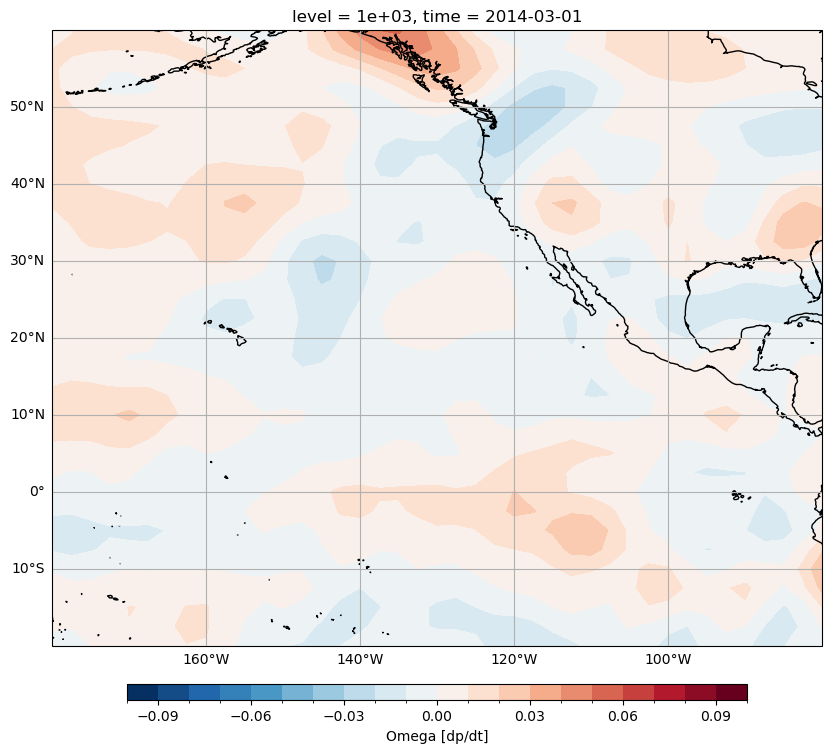

In [30]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines(resolution='50m', color='black', linewidth=1)

ax.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

cbar_kwargs = {'shrink':0.8, 'aspect':40,
               'label':r'Omega [dp/dt]',
               'orientation':'horizontal', 
               'pad':0.05}

gl = ax.gridlines(draw_labels=True)
# gl.xlocator = mticker.FixedLocator(np.arange())
# gl.ylocator = mticker.FixedLocator(np.arange())
gl.right_labels = False
gl.top_labels = False

v_levels = np.arange(-0.1, 0.11, 0.01)

omega_surf_anom.sel(time='2014-03-01').plot.contourf(ax=ax,
                                                     levels = v_levels,
                                     transform=ccrs.PlateCarree(),
                                     cbar_kwargs=cbar_kwargs)
plt.show()

## Snow

In [31]:
snotel = xr.open_dataset('./data/snotel/snowPillowSWE_westernNA_level2_ncc.nc')
# get station agency
swe_l1 = xr.open_dataset('./data/snotel/snowPillowSWE_westernNA_level1_ncc.nc')

In [32]:
snotel_decoded = xr.decode_cf(snotel)

In [33]:
snotel_decoded['siteID'][0,0].values

array(b'3', dtype='|S1')

In [34]:
snotel['agency'] = swe_l1['agency']
# https://stackoverflow.com/a/73073957
snotel['agency'] = snotel.agency.astype('O').sum(dim='agencyName').astype('U')
snotel['siteID'] = snotel.siteID.astype('O').sum(dim='charLenID').astype('U')
snotel['siteName'] = snotel.siteName.astype('O').sum(dim='charLenName').astype('U')

In [35]:
snotel['date_matlab'] = snotel.date_matlab - 679352

snotel.date_matlab.attrs["units"] = "days since 1860-01-01"
snotel = xr.decode_cf(snotel)

In [36]:
xr.decode_cf(snotel)['date_matlab'][0,0,0].values

numpy.datetime64('1960-10-01T00:00:00.000000000')

In [37]:
swe_da = snotel.swe_level2
lons = snotel.longitude.sel(single=0)
lats = snotel.latitude.sel(single=0)
elev = snotel.elevation.sel(single=0)
time = snotel.date_matlab.transpose('years', 'time', 'sites').stack(xy=['years', 'time']).sel(sites=0).reset_index('xy').reset_coords(names=['years', 'time'], drop=True)

In [38]:
swes = snotel.swe_level2.transpose('years', 'time', 'sites').stack(xy=['years', 'time']).reset_index('xy').reset_coords(names=['years', 'time'], drop=True)
swes = swes.assign_coords({'latitude':lats,
                           'longitude': lons,
                           'elevation':elev,
                           'agency':snotel.agency,
                           'siteID':snotel.siteID,
                           'time': time})
swes = swes.rename({'xy':'time'})
swes = swes.assign_attrs(units='mm')
swes['time'] = swes['time'].to_index()
swes = swes.drop_duplicates(dim='time', keep=False)


In [39]:
swes

<xarray.DataArray 'swe_level2' (sites: 1065, time: 21520)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    latitude   (sites) float32 ...
    longitude  (sites) float32 ...
    elevation  (sites) float32 ...
    agency     (sites) <U4 ...
    siteID     (sites) <U7 ...
  * time       (time) datetime64[ns] 1960-10-01 1960-10-02 ... 2019-09-01
Dimensions without coordinates: sites
Attributes:
    Description:  Snow water equivalent, mm
    units:        mm

In [40]:
delta_swes = xr.apply_ufunc(
    lambda x, mean, stddev: (x - mean)/stddev, 
    swes.groupby('time.month'),
    swes.groupby('time.month').mean(),
    swes.groupby('time.month').std()
).drop('month')

In [41]:
swe_mon = swes.resample(time='MS').mean()

In [42]:
delta_swes_mon = xr.apply_ufunc(
    lambda x, mean, stddev: (x - mean)/stddev, 
    swe_mon.groupby('time.month'),
    swe_mon.groupby('time.month').mean(),
    swe_mon.groupby('time.month').std()
).drop('month')

In [43]:
swe_ts_monthly = swes.mean(dim='sites').resample(time='MS').mean()

In [44]:
eco_regions = ['Middle Rockies',
               'Klamath Mountains',
               'Sierra Nevada',
               'Wasatch and Uinta Mountains',
               'Southern Rockies',
               'Idaho Batholith',
               'Columbia Mountains/Northern Rockies',
               'Canadian Rockies',
               'North Cascades',
               'Blue Mountains',
               'Cascades',
               'Eastern Cascades Slopes and Foothills',
               'Central Basin and Range',
               'Arizona/New Mexico Mountains',
               'Northern Basin and Range']

In [45]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('./data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(eco_regions)]

In [46]:
# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

In [47]:
# create DataFrame 
test2 = snotel[['agency','siteID','latitude', 'longitude', 'elevation']].to_dataframe()
test2 = test2.droplevel('single')

# convert DataFrame to GeoDataFrame
test_gdf = gpd.GeoDataFrame(test2['agency'],
                            geometry=gpd.points_from_xy(test2['longitude'],
                                                        test2['latitude']))

test_gdf.set_crs(crs_proj4, inplace=True)

,agency,geometry
sites,,
0,NRCS,POINT (-120.790 41.240)
1,NRCS,POINT (-112.270 37.520)
2,NRCS,POINT (-111.960 45.600)
3,NRCS,POINT (-150.890 61.750)
4,NRCS,POINT (-121.700 47.780)
...,...,...
1060,AB,POINT (-115.630 55.020)
1061,AB,POINT (-110.494 56.618)
1062,YK,POINT (-135.197 60.522)


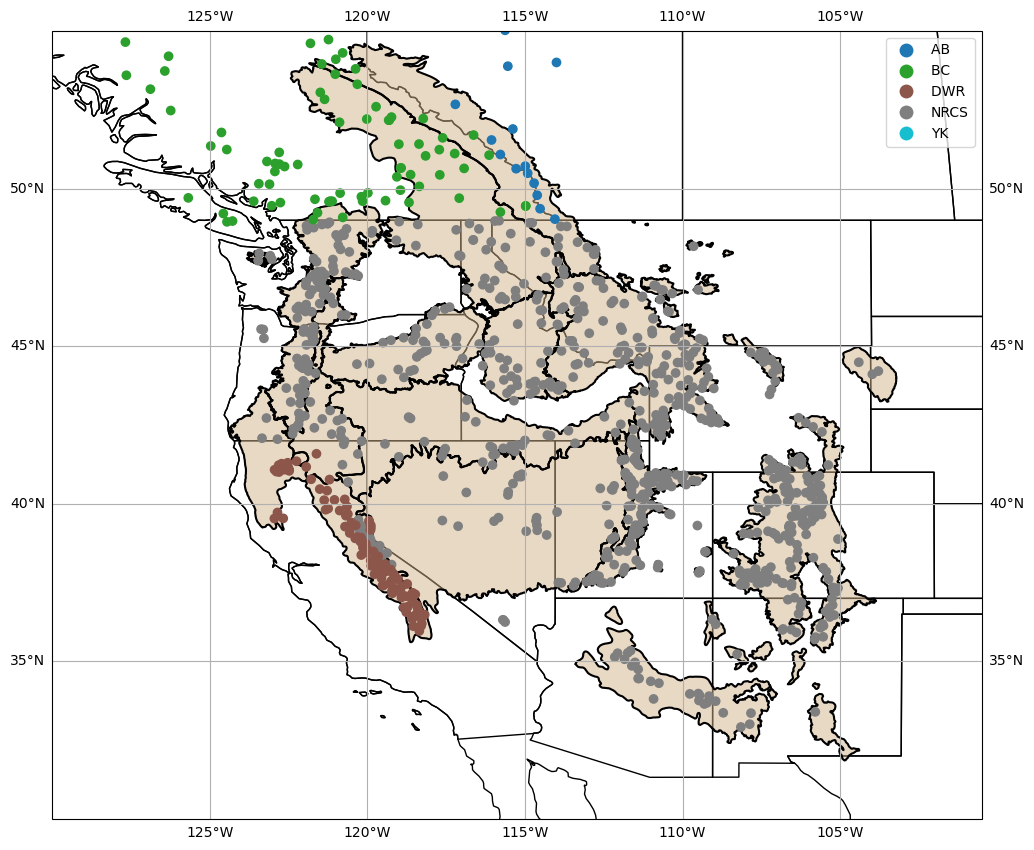

In [48]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={
    "projection": ccrs.PlateCarree()})
ax.coastlines(resolution='50m',
              color='black', linewidth=1)
ax.set_extent([-130, -100.5, 30, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.add_geometries(wus_eco['geometry'],
                  crs=crs, color='tan', alpha=0.5)
wus_eco.boundary.plot(ax=ax, color='k')
test_gdf.plot(column='agency',
              ax=ax, zorder=2,
              legend=True, cmap='tab10')
gl = ax.gridlines(draw_labels=True)


In [49]:
# wus_eco = wus_eco.to_crs(crs_proj4)
test_gdf_w_ecoregions = test_gdf.sjoin(wus_eco, how='inner', predicate='intersects')

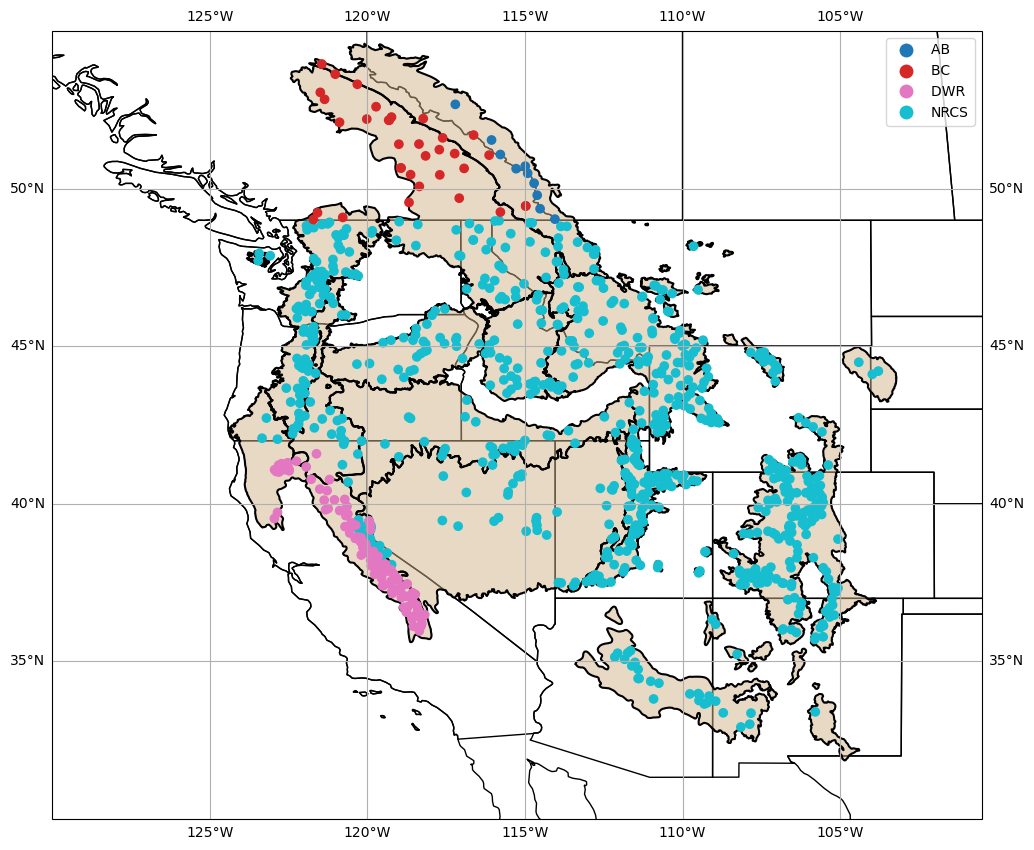

In [50]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={
    "projection": ccrs.PlateCarree()})
ax.coastlines(resolution='50m',
              color='black', linewidth=1)
ax.set_extent([-130, -100.5, 30, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)
ax.add_geometries(wus_eco['geometry'],
                  crs=crs, color='tan', alpha=0.5)
wus_eco.boundary.plot(ax=ax, color='k')
test_gdf_w_ecoregions.plot(column='agency',
              ax=ax, zorder=2,
              legend=True, cmap='tab10')
gl = ax.gridlines(draw_labels=True)


In [51]:
def subsetSNOTEL(ecoName):
    sub = gdf[gdf['NA_L3NAME']==ecoName]
    sub_pc = sub.to_crs(crs_proj4)
    test_gdf_w_ecoregions = test_gdf.sjoin(sub_pc, how='inner', predicate='intersects')
    return(delta_swes_mon.isel(sites=test_gdf_w_ecoregions.index))

In [52]:
swe_idaho = subsetSNOTEL('Idaho Batholith')
swe_mr = subsetSNOTEL('Middle Rockies')
swe_sn = subsetSNOTEL('Sierra Nevada')
swe_sr = subsetSNOTEL('Southern Rockies')
swe_wc = subsetSNOTEL('Cascades')

In [133]:
for e in eco_regions:
    print(e)
    swe_e = subsetSNOTEL(e)
    e_str = e.replace(' ','_').replace('/','_')
    swe_e.to_netcdf('./data/processed/snow_by_eco/snow_'+e_str+'.nc')

Middle Rockies
Klamath Mountains
Sierra Nevada
Wasatch and Uinta Mountains
Southern Rockies
Idaho Batholith
Columbia Mountains/Northern Rockies
Canadian Rockies
North Cascades
Blue Mountains
Cascades
Eastern Cascades Slopes and Foothills
Central Basin and Range
Arizona/New Mexico Mountains
Northern Basin and Range


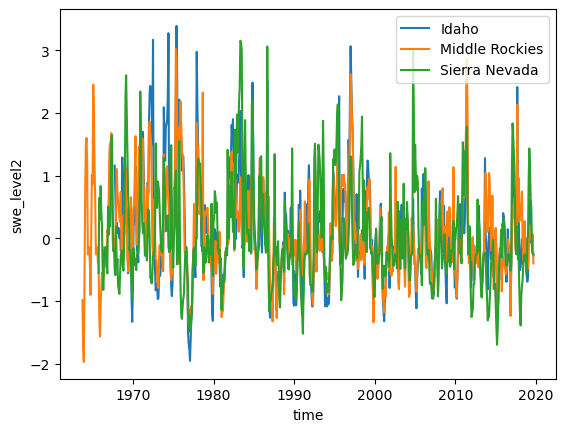

In [53]:
swe_idaho.mean(dim='sites').plot()
swe_mr.mean(dim='sites').plot()
swe_sn.mean(dim='sites').plot()
plt.xticks(rotation=0, ha='center')
plt.legend(['Idaho', 'Middle Rockies', 'Sierra Nevada'])
plt.show()

## 

## Figure Creations

In [54]:
from datetime import datetime

def plotVars(timestr):
    timestr_dt = datetime.strptime(timestr, '%Y-%m-%d')
    fig = plt.figure(figsize=(12, 15), constrained_layout=True)
    # create gridspec
    gs = fig.add_gridspec(1,3, width_ratios=[1,1,1],
                          height_ratios=[1])
    
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.coastlines(resolution='50m', color='black', linewidth=1)

    ax1.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

    cbar_kwargs = {'shrink':0.8, 'aspect':40,
                   'label':r'sst [$^\circ$C]',
                   'orientation':'horizontal', 'pad':0.01}

    gl = ax1.gridlines(draw_labels=True)
    # gl.xlocator = mticker.FixedLocator(np.arange())
    # gl.ylocator = mticker.FixedLocator(np.arange())
    gl.right_labels = False
    gl.top_labels = False

    sst_levels = np.arange(-5,5.1,0.5)

    ssta_np.sel(time=timestr).plot.contourf(ax=ax1,
                                     levels = sst_levels,
                                     transform=ccrs.PlateCarree(),
                                     cbar_kwargs=cbar_kwargs)
    ax1.set_title('')
    ax1.set_title('a) SST Anomalies\nERSSTv5', loc='left')
    ax1.set_title('{}\n\N{degree sign}C'.format(timestr_dt.strftime('%Y-%b')), loc='right')
    
    
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax2.coastlines(resolution='50m', color='black', linewidth=1)

    ax2.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())
    gl = ax2.gridlines(draw_labels=True)
    # gl.xlocator = mticker.FixedLocator(np.arange(-180,-115,10))
#     gl.ylocator = mticker.FixedLocator(np.arange(35,75.1,10))
    gl.right_labels = False
    gl.top_labels = False
    # gl.xlines=False
    # gl.ylines=False
    # ax.add_feature(cfeature.STATES, alpha=0.3)
    #     ax.add_feature(cfeature.LAKES, alpha=0.5)
    #     ax.add_feature(cfeature.RIVERS)
    # ax.add_feature(cfeature.OCEAN)
    #     ax.add_feature(cfeature.LAND)

    cbar_kwargs = {'shrink':0.8, 'aspect':40,
                   'label':r'SLP [mb]',
                   'orientation':'horizontal', 'pad':0.01}
    slp_levels = np.arange(-20,20.1,1)
    slp_anomalies.sel(time=timestr).plot.contourf(ax=ax2,
                                              levels=slp_levels,
                                              transform=ccrs.PlateCarree(),
                                              cbar_kwargs=cbar_kwargs)
    ax2.set_title('')
    ax2.set_title('b) Surface SLP Anomalies\nNCEP-NCAR Reanalyis I', loc='left')
    ax2.set_title('{}\nmb'.format(timestr_dt.strftime('%Y-%b')), loc='right')

    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    ax3.coastlines(resolution='50m', color='black', linewidth=1)

    ax3.set_extent([180, 280, -20, 60], crs=ccrs.PlateCarree())

    cbar_kwargs = {'shrink':0.8, 'aspect':40,
                   'label':r'Omega [Pa/s]',
                   'orientation':'horizontal', 'pad':0.01}

    gl = ax3.gridlines(draw_labels=True)
    # gl.xlocator = mticker.FixedLocator(np.arange())
    # gl.ylocator = mticker.FixedLocator(np.arange())
    gl.right_labels = False
    gl.top_labels = False

    v_levels = np.arange(-0.1, 0.11, 0.01)

    omega_surf_anom.sel(time=timestr).plot.contourf(ax=ax3,
                                                    levels = v_levels,
                                                    transform=ccrs.PlateCarree(),
                                                    cbar_kwargs=cbar_kwargs)
    ax3.set_title('')
    ax3.set_title('c) Surface Omega Anomalies\nNCEP-NCAR Reanalyis I', loc='left')
    ax3.set_title('{}\nPa/s'.format(timestr_dt.strftime('%Y-%b')), loc='right')
    plt.show()


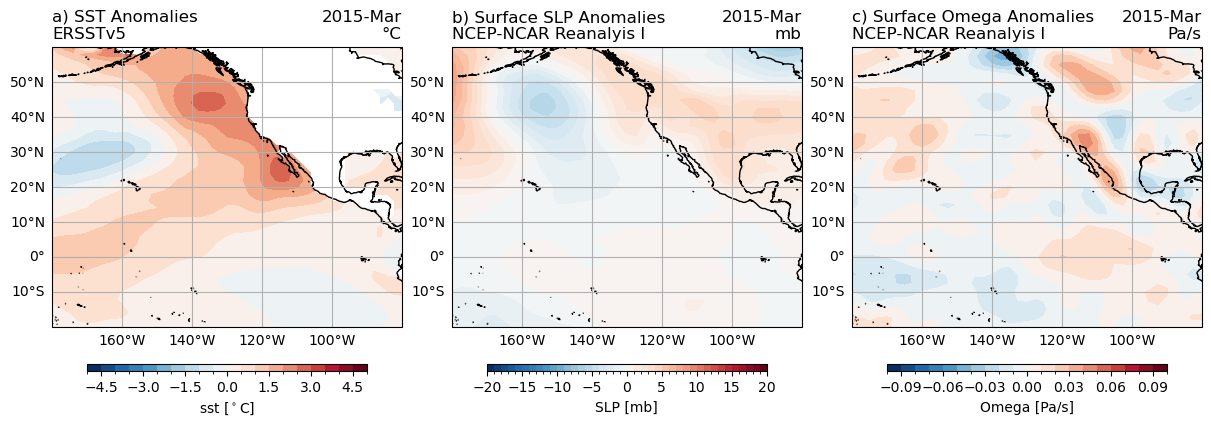

In [55]:
plotVars('2015-03-01')

## Hovmoller?

In [56]:
lons = ((np.arange(180,280.1,20)- 180) % 360) - 180
lons

array([-180., -160., -140., -120., -100.,  -80.])

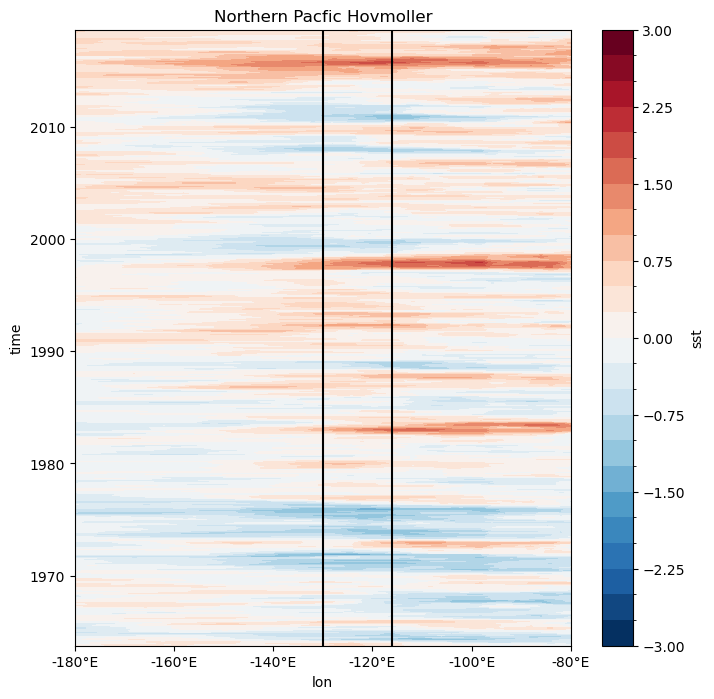

In [58]:
cbar_kwargs = {'shrink':0.6, 'aspect':40,
               'label':r'sst [$^\circ$C]'}
plt_levels = np.arange(-5,5.1,0.25)

fig, ax = plt.subplots(figsize=(8,8))
lons = ((np.arange(180,281,20)- 180) % 360) - 180

ssta_np.mean(dim='lat').plot.contourf(ax=ax, x='lon', y='time', levels = sst_levels)
plt.axvline(x=230, color='k')
plt.axvline(x=244, color='k')
ax.set_xticks(np.arange(180,281,20))
ax.set_xticklabels(['{}\N{degree sign}E'.format(i) for i in ((np.arange(180,281,20)- 180) % 360) - 180])
# ssta.mean(dim='lat').plot.contour(ax=ax, x='lon', y='time', colors='k')

plt.title('Northern Pacfic Hovmoller')
plt.show()

In [59]:
ssta_np

<xarray.DataArray 'sst' (time: 660, lat: 41, lon: 51)>
array([[[-1.0747433e-02, -2.0564985e-01, -3.8904524e-01, ...,
         -4.8840642e-01, -4.8273206e-01, -4.5372105e-01],
        [ 4.0315151e-02, -9.8770618e-02, -2.6283550e-01, ...,
         -4.8315859e-01, -5.1066613e-01, -5.4970026e-01],
        [ 3.6093235e-02, -5.1420212e-02, -1.8130875e-01, ...,
         -7.1168160e-01, -9.1455674e-01, -1.0287509e+00],
        ...,
        [-6.1793900e-01, -6.0923767e-01, -6.0748672e-01, ...,
         -9.3807220e-02, -6.0647964e-02, -1.0748100e-01],
        [-7.3677635e-01, -7.5333214e-01, -7.7700996e-01, ...,
         -1.6039848e-01, -1.4908791e-01, -1.4390945e-01],
        [-8.3123016e-01, -8.6899948e-01, -9.0429688e-01, ...,
         -1.7796135e-01, -1.8140030e-01, -1.7215538e-01]],

       [[-8.4359407e-02, -1.5768147e-01, -3.3119416e-01, ...,
         -8.6806864e-02, -6.9920078e-02, -7.4515224e-02],
        [-5.8157921e-02, -7.1159363e-02, -1.6920662e-01, ...,
         -2.2615731e-02, -3.7550271e-02, -1.2574887e-01],
        [-6.3828468e-02, -5.7821274e-02, -1.0362196e-01, ...,
         -1.5803117e-01, -3.3010298e-01, -4.9133605e-01],
...
        [ 5.2789497e-01,  5.4681969e-01,  5.5519295e-01, ...,
         -3.6508942e-01, -4.3280029e-01, -4.3091202e-01],
        [ 4.5244408e-01,  4.8362923e-01,  5.0988388e-01, ...,
         -1.9639778e-01, -2.4734879e-01, -2.8513336e-01],
        [ 3.9120865e-01,  4.1214371e-01,  4.3557739e-01, ...,
         -6.8233490e-02, -9.3875885e-02, -1.3094139e-01]],

       [[ 2.5774727e+00,  2.4145536e+00,  2.2549133e+00, ...,
          2.4841118e-01,  8.0623150e-02,  2.8050423e-02],
        [ 2.1454000e+00,  2.0204258e+00,  1.8744135e+00, ...,
          1.4304972e-01,  1.3970375e-02, -5.9686184e-02],
        [ 1.7613888e+00,  1.6457529e+00,  1.5167999e+00, ...,
          3.8702917e-01,  4.3026018e-01,  3.9074612e-01],
        ...,
        [ 5.9260368e-01,  6.0887527e-01,  6.1459732e-01, ...,
         -2.5359726e-01, -2.8940010e-01, -2.8232956e-01],
        [ 5.2020073e-01,  5.5469131e-01,  5.8231354e-01, ...,
         -6.1645508e-02, -1.2525368e-01, -1.7250443e-01],
        [ 4.5740891e-01,  4.8324776e-01,  5.0803375e-01, ...,
          8.9860916e-02,  4.2751312e-02, -1.1081696e-02]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 60.0 58.0 56.0 54.0 52.0 ... -14.0 -16.0 -18.0 -20.0
  * lon      (lon) float32 180.0 182.0 184.0 186.0 ... 274.0 276.0 278.0 280.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2018-09-01

In [60]:
slp_anomalies

<xarray.DataArray 'slp' (time: 660, lat: 33, lon: 41)>
array([[[-0.6182251 , -1.0181885 , -1.4172363 , ..., -2.024414  ,
         -2.1734009 , -2.5142212 ],
        [ 0.43292236, -0.36743164, -1.0775146 , ..., -1.1029053 ,
         -0.84729004, -0.7897949 ],
        [ 1.6404419 ,  0.82891846,  0.07171631, ..., -0.36108398,
          0.13256836,  0.36071777],
        ...,
        [-0.4500122 , -0.46990967, -0.35253906, ..., -0.12896729,
         -0.08526611, -0.06231689],
        [-0.6543579 , -0.6599121 , -0.4572754 , ...,  0.11535645,
          0.19042969,  0.2355957 ],
        [-0.39300537, -0.46331787, -0.3554077 , ...,  0.42852783,
          0.4335327 ,  0.40167236]],

       [[ 7.721863  ,  8.135376  ,  8.253906  , ..., -1.1068115 ,
         -0.4121704 ,  0.37121582],
        [ 6.7632446 ,  6.8584595 ,  6.777466  , ..., -0.05462646,
          0.31329346,  0.62713623],
        [ 4.522949  ,  4.4370728 ,  4.3515015 , ..., -0.1552124 ,
         -0.03778076, -0.05645752],
...
        [-0.7246094 , -0.9202881 , -1.0901489 , ...,  1.631897  ,
          1.6223145 ,  1.3612671 ],
        [-0.8545532 , -1.1026611 , -1.3079224 , ...,  1.8283691 ,
          1.6617432 ,  1.6010132 ],
        [-1.2501221 , -1.6091919 , -1.8588867 , ...,  1.9838257 ,
          1.8050537 ,  1.6088257 ]],

       [[ 5.4613037 ,  6.728821  ,  7.944397  , ...,  2.3186035 ,
          2.3504639 ,  2.3139038 ],
        [ 5.777893  ,  7.0946045 ,  8.380676  , ...,  2.7229004 ,
          2.6516113 ,  2.5562134 ],
        [ 5.465027  ,  6.8012085 ,  8.164368  , ...,  3.3217163 ,
          3.2427368 ,  3.2371826 ],
        ...,
        [-1.104248  , -1.1257935 , -1.0673218 , ..., -0.27508545,
         -0.44067383, -0.6542969 ],
        [-1.0593872 , -1.0739746 , -0.9525757 , ..., -0.1385498 ,
         -0.4517212 , -0.38928223],
        [-0.8703613 , -0.8845825 , -0.7904053 , ..., -0.01202393,
         -0.234375  , -0.31384277]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 60.0 57.5 55.0 52.5 50.0 ... -12.5 -15.0 -17.5 -20.0
  * lon      (lon) float32 180.0 182.5 185.0 187.5 ... 272.5 275.0 277.5 280.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2018-09-01

---

In [108]:
# test ccm
swe_m_anom = delta_swes_mon.sel(time=time_slice).mean(dim='sites').to_dataframe()
sst_m_anom = ssta_np.isel(lon=34, lat=35).to_dataframe().drop(['lon', 'lat'], axis=1)
slp_m_anom = slp_anomalies.isel(lon=0, lat=1).to_dataframe().drop(['lon', 'lat'], axis=1)

ssta_np.isel(lon=24, lat=20)

<xarray.DataArray 'sst' (time: 660)>
array([ 5.48362732e-02,  4.69984055e-01,  8.85715485e-02, -3.54911804e-01,
       -5.09241104e-01, -7.53990173e-01, -7.42084503e-01, -2.95152664e-01,
       -2.24969864e-01, -3.30743790e-01, -7.02850342e-01, -9.75866318e-01,
       -7.07059860e-01, -6.27717972e-01, -2.27104187e-01, -4.31140900e-01,
       -5.59474945e-01, -7.24422455e-01, -4.72839355e-01, -8.09698105e-01,
       -7.24060059e-01, -1.11222458e+00, -1.12580681e+00, -3.62058640e-01,
       -5.84880829e-01, -1.17780685e-01, -5.21373749e-02, -3.63773346e-01,
       -5.32329559e-01, -1.52015686e-03,  1.74364090e-01,  4.22044754e-01,
        3.35121155e-03,  2.25873947e-01,  2.22242355e-01, -1.90547943e-01,
       -8.71772766e-02,  2.05678940e-01,  2.69329071e-01, -2.04011917e-01,
       -3.24972153e-01,  3.23492050e-01,  5.10433197e-01,  4.20526505e-01,
        2.86685944e-01,  1.19400024e-03, -1.65287018e-01,  8.12969208e-02,
       -6.28700256e-02,  1.94677353e-01, -1.00313187e-01,  8.27808380e-02,
        7.89930344e-01,  4.44028854e-01,  5.21095276e-01,  7.95547485e-01,
        9.42831039e-01,  5.99069595e-01,  4.90894318e-01,  3.66020203e-01,
        4.01964188e-01,  2.77446747e-01,  2.75541306e-01,  7.11204529e-01,
        6.77751541e-01, -1.14061356e-01,  2.86783218e-01,  2.46101379e-01,
        5.36457062e-01, -2.97477722e-01, -6.78207397e-01, -1.07148933e+00,
       -7.09072113e-01, -8.44312668e-01, -4.14422989e-01, -3.01984787e-01,
       -3.28130722e-01, -5.00717163e-01, -4.66648102e-01, -1.10862160e+00,
...
       -8.64242554e-01, -9.58612442e-01, -1.31495476e+00, -1.27870750e+00,
       -8.58228683e-01, -3.57952118e-01, -1.45874023e-02, -3.50774765e-01,
       -5.75363159e-01, -6.27761841e-01, -2.59185791e-01,  2.98748016e-02,
       -4.00390625e-02,  4.28089142e-01,  4.45365906e-02,  3.09963226e-02,
       -4.83779907e-02, -1.61354065e-01,  6.05010986e-02, -1.13735199e-02,
        8.20674896e-02,  4.85784531e-01,  4.95595932e-01,  5.82618713e-02,
        2.63746262e-01,  6.24963760e-01,  6.09848022e-01,  9.71788406e-01,
        1.06760025e+00,  9.20690536e-01,  1.18232536e+00,  1.14267921e+00,
        1.34076881e+00,  1.09393501e+00,  9.59253311e-01,  8.44079971e-01,
        1.02544022e+00,  1.87198448e+00,  2.06527138e+00,  2.00205040e+00,
        2.12057114e+00,  1.13451004e+00,  4.14644241e-01,  4.38108444e-01,
        4.97652054e-01,  5.60586929e-01,  7.28355408e-01,  5.89309692e-01,
        8.75722885e-01,  7.01486588e-01,  1.01204300e+00,  8.56664658e-01,
        6.72325134e-01,  6.31423950e-01,  5.39752960e-01,  8.72835159e-01,
        1.02197838e+00,  8.77708435e-01,  8.65142822e-01,  6.48237228e-01,
        7.42055893e-01,  4.93282318e-01,  5.95514297e-01,  5.26603699e-01,
        3.45542908e-01,  1.11538124e+00,  1.36987686e+00,  1.30850410e+00,
        1.26043701e+00,  1.23771858e+00,  1.51171112e+00,  1.26191330e+00,
        8.25841904e-01,  8.02059174e-01,  9.41114426e-01,  7.33610153e-01],
      dtype=float32)
Coordinates:
    lat      float32 20.0
    lon      float32 228.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2018-09-01

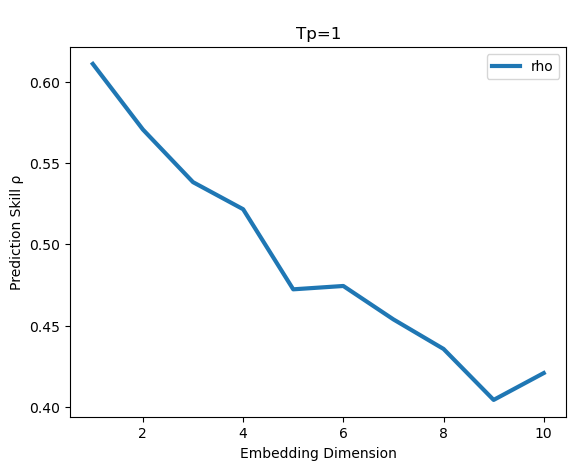

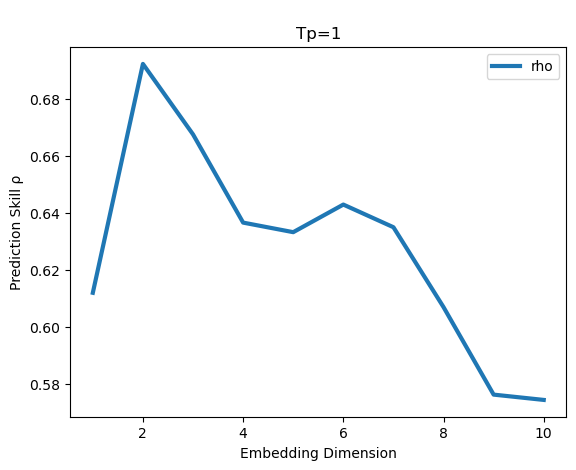

In [118]:
df = swe_m_anom.join(sst_m_anom)
d1 = EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='sst')
d2 = EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='swe_level2')

ed1 = d1[d1['rho'] == d1['rho'].max()]['E'].item()
ed2 = d2[d2['rho'] == d2['rho'].max()]['E'].item()

In [119]:
ed2

2.0

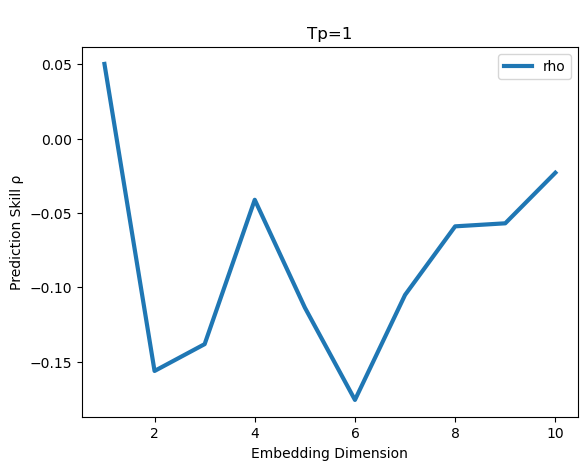

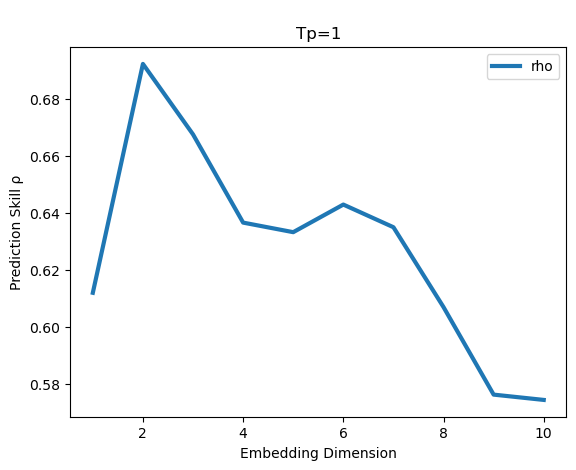

,E,rho
0,1.0,0.611937
1,2.0,0.692188
2,3.0,0.667476
3,4.0,0.636546
4,5.0,0.633192
5,6.0,0.642872
6,7.0,0.634925
7,8.0,0.606910
8,9.0,0.576230
9,10.0,0.574372


In [86]:
df = swe_m_anom.join(slp_m_anom)
EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='slp')
EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='swe_level2')

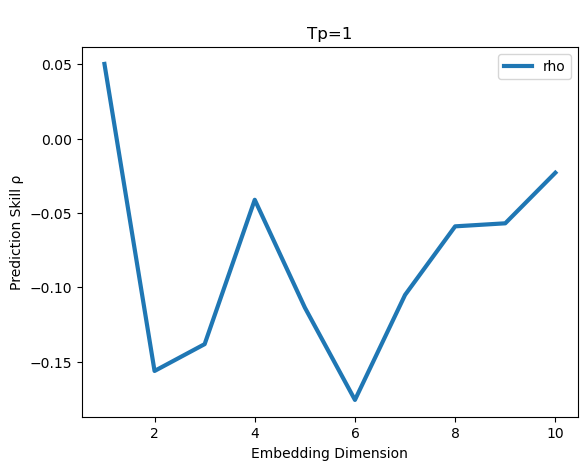

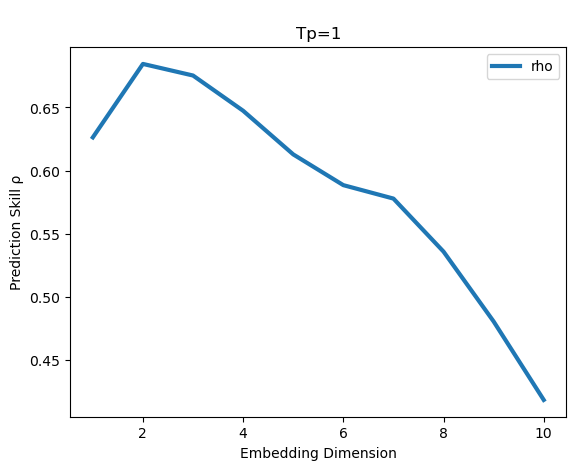

,E,rho
0,1.0,0.626274
1,2.0,0.684497
2,3.0,0.675306
3,4.0,0.647371
4,5.0,0.612795
5,6.0,0.588418
6,7.0,0.577766
7,8.0,0.535727
8,9.0,0.480357
9,10.0,0.418189


In [87]:
df = sst_m_anom.join(slp_m_anom)
EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='slp')
EmbedDimension(dataFrame=df.reset_index(), lib="1 100", pred="201 500", columns='sst')

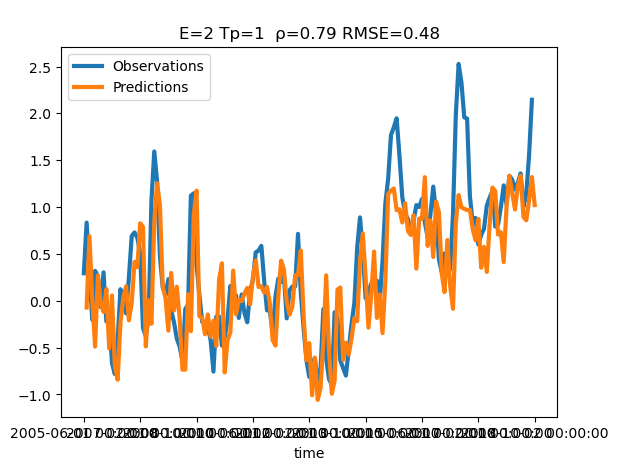

,time,Observations,Predictions,Pred_Variance
0,2005-06-01 00:00:00,0.293540,NaN,NaN
1,2005-07-01 00:00:00,0.833661,-0.072294,0.005370
2,2005-08-01 00:00:00,0.300054,0.689222,0.131298
3,2005-09-01 00:00:00,-0.202809,0.004040,0.005805
4,2005-10-01 00:00:00,0.319719,-0.488737,0.091827
...,...,...,...,...
156,2018-06-01 00:00:00,0.999406,0.895060,0.100786
157,2018-07-01 00:00:00,1.138035,0.859099,0.072504
158,2018-08-01 00:00:00,1.553794,1.070917,0.059247
159,2018-09-01 00:00:00,2.145400,1.320149,0.073598


In [89]:
Simplex(dataFrame=df.reset_index(), lib="1 500", pred="501 660", columns='sst', E=2, showPlot=True)

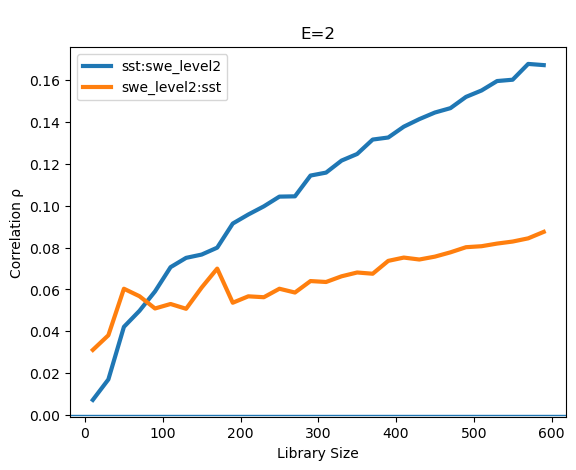

Elapsed Time: 0.8902062666666666 min


In [93]:
t = process_time()
CCM(dataFrame = df.reset_index(),
    E=2,
    columns='sst', target='swe_level2', libSizes='10 600 20', sample=100, showPlot=True)

elapsed_time = process_time() - t
print('Elapsed Time: {} min'.format(elapsed_time/60))

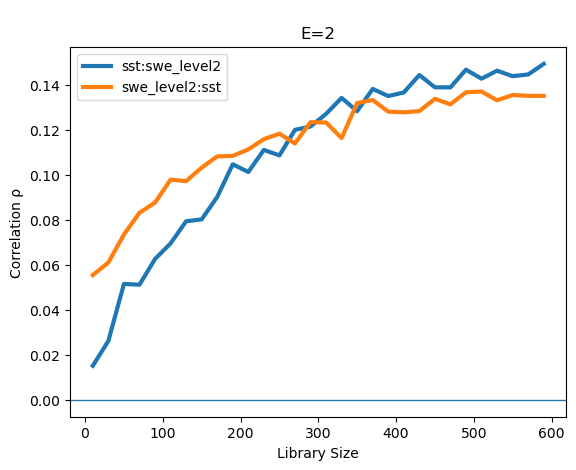

Elapsed Time: 0.8902185666666668 min


In [94]:
t = process_time()
CCM(dataFrame = df.reset_index(),
    E=2,
    tau=-3,
    columns='sst', target='swe_level2', libSizes='10 600 20', sample=100, showPlot=True)

elapsed_time = process_time() - t
print('Elapsed Time: {} min'.format(elapsed_time/60))

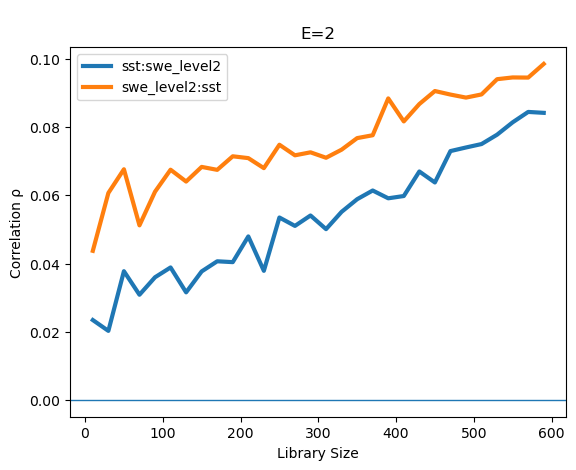

Elapsed Time: 0.8891701166666669 min


In [97]:
t = process_time()
results = CCM(dataFrame = df.reset_index(),
              E=2,
              tau=-6, includeData=True,
              columns='sst', target='swe_level2',
              libSizes='10 600 20',
              sample=100, showPlot=True)

elapsed_time = process_time() - t
print('Elapsed Time: {} min'.format(elapsed_time/60))

In [98]:
results

{'LibMeans':     LibSize  sst:swe_level2  swe_level2:sst
 0      10.0        0.023424        0.043723
 1      30.0        0.020247        0.060690
 2      50.0        0.037750        0.067644
 3      70.0        0.030846        0.051195
 4      90.0        0.035969        0.061060
 5     110.0        0.038849        0.067513
 6     130.0        0.031547        0.064046
 7     150.0        0.037685        0.068338
 8     170.0        0.040658        0.067474
 9     190.0        0.040407        0.071451
 10    210.0        0.047947        0.070914
 11    230.0        0.037856        0.067977
 12    250.0        0.053499        0.074837
 13    270.0        0.051033        0.071740
 14    290.0        0.054091        0.072615
 15    310.0        0.050088        0.071019
 16    330.0        0.055161        0.073393
 17    350.0        0.058866        0.076782
 18    370.0        0.061416        0.077623
 19    390.0        0.059130        0.088424
 20    410.0        0.059799        0.08167

In [9]:
sst_anom = xr.open_dataset('./data/SST_anoms.nc')

In [10]:
sst_anom

<xarray.Dataset>
Dimensions:  (lat: 41, lon: 51, time: 660)
Coordinates:
  * lat      (lat) float32 60.0 58.0 56.0 54.0 52.0 ... -14.0 -16.0 -18.0 -20.0
  * lon      (lon) float32 180.0 182.0 184.0 186.0 ... 274.0 276.0 278.0 280.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2018-09-01
Data variables:
    sst      (time, lat, lon) float32 ...